# Introduction

The multi-armed bandit problem is the problem of choosing between exploration and exploitation. <br>
**Exploitation** is making the best decision given the information you have. <br>
**Exploration** is gathering more information about the environment so that you can make a potentially better decision.<br>


E.g. 1) <br>
You have access to **n** slot machines at a casino. Each machine gives you a certain probability of winning. Your objective is to maximize the expected reward from playing on these slot machines (action is to choose between the **n** machines) over **N** plays (e.g. N = 100)

E.g. 2) <br>
A doctor has to select betwen **n** experimental treatments for a series of **N** ill patients. Your objective is to maximize the survival of these patients by choosing amonng these **n** treatments over the **N** patients.

E.g.3) <br>
You have to pick a restaurant for dinner fron **n** possible restaurants. Your objective is to maximize your satisfaction fron dinners over the next **N** weekends

E.g. 4) <br>
You have to choose between **n** values for a specific hyperparameter for a model, you have a limited time budget in which you can fit a model **N** times.  

In [1]:
from IPython.display import HTML
HTML("""
    <video  width = "640" height = "300" alt="test" controls>
        <source src="multi_armed_bandit.webm" type="video/mp4">
    </video>
""")

Identifying a strategy to maximize returns over the long run can involve making sacrifices in the short term. If you have many rounds to play or several time steps at which you can take actions, it may be better to explore.

##  Formal Defintion

$\mathcal{A}$ is a set of actions(or arms) <br>
$\mathcal{R}^a(r) = \mathbb{P}[R =r|A =a]$ is an unknown probability distribution over rewards for each arm <br>

At each time $t$ , the agent selects an action $A_t \in \mathcal{A}$ <br>
The environment generates a reward $R_t \sim \mathcal{R}^{A_t}$

The goal is to maximize the cumulative reward $\sum_{\tau=1}^{t} R_{\tau}$

### Regret Minimization

The **action value** is the mean reward from taking an action $q(a) = \mathbb{E}[R|A=a]$ <br>
The optimal value $v_*$ is $v_* = q(a^*) = \max_{a \in \mathcal{A}}(q(a))$

Regret is how much worse than $v_*$ we do. It is the opportunity loss for one step<br>
$$I_t = \mathbb{E}[v_* - q(A_t)]$$

Total regret is the total opportunity loss <br>
$$L_t = \mathbb{E}[\sum_{\tau=1}^{t} v_* - q(A_\tau)]$$

Maximizing cumulative reward $ \equiv $ Minimizing Total Regret

**Theoretical analysis** of MAB algorithms are carried out within the regret minimization framework rather than the reward maximization framework

### A good algorithm

The **count** $N_t(a)$ is the expected number of selections for action $a$ <br>
The **gap** $\Delta_a$ is the difference in value between action a and optimal action $a^*$
$$\Delta_a = v_* - q(a)$$

Regret is a function of gaps and counts<br>
$$L_t = \mathbb{E} [\sum_{\tau=1}^{t} v_* - q(A_{\tau})]$$ <br>
$$    = \sum _{a \in \mathcal{A}} \mathbb{E}[N_t(a)](v_* - q(a))$$ <br>
$$    = \sum_{a \in \mathcal{A}} \mathbb{E} [N_t(a)] \Delta_a$$

During exploration, a good algorithm will pick an action with a large gap few times, while it picks actions with small gaps more frequently

## Algorithms

The most commonly used algorithms to solve the Multi Armed Bandit Problem include: <br>
1) Epsilon Greedy <br>
2) Optimistic Initial Values <br>
3) Upper Confidence Bound (UCB1) <br>
4) Thompson Sampling (Bayesian Bandit)

## Experimental Set Up

Consider an N armed bandit (N = 4) where each arm has a different intrinsic probability ($\theta$) of yielding a reward. The reward is binary (reward = 1 , no reward = 0). We want to identify the arm that yields the highest reward

In [2]:
import pandas as pd
df = pd.DataFrame({'Arm 1': [0.2],'Arm 2':[0.4],'Arm 3': 0.6, 'Arm 4': 0.8})
df.index = ['Reward Probability']
df

,Arm 1,Arm 2,Arm 3,Arm 4
Reward Probability,0.2,0.4,0.6,0.8


We will estimate the reward probability(distribution)of each bandit by keeping a running average of the reward using the formula: <br>
$$ q_{k+1} = q_k + \frac{1}{k}[R_k - q_k] $$

In [3]:
class Bandit:
    def __init__(self,p):
        self.p = p #intrinsic reward probability of bandit
        self.p_estimate = 0
        self.N = 0 #number of trails
        
    def pull(self):
        return np.random.random() < self.p
    
    def update(self,x):
        self.N += 1
        self.p_estimate = self.p_estimate + 1/self.N*(x - self.p_estimate)
        

Let the series of rewards observed be [0,0,0,1,1]

In [4]:
B = Bandit(0.4)

In [5]:
rewards = [0,0,0,1,1]
for r in rewards:
    B.update(r)
    print(B.p_estimate)

0.0
0.0
0.0
0.25
0.4


### 1) Epsilon Greedy

In a greedy strategy , we always select the best action given the current estimate of the action values. 
$$ A_t = argmax_a Q_t(a)$$

In an $\epsilon$ greedy strategy, with a small probability $\epsilon$ we choose an action randomly, while with probability $1 - \epsilon$ , we act greedily

In [6]:
import numpy as np
def epsilon_greedy(bandits,eps,t):
    if np.random.random() < eps:
        return np.random.randint(len(bandits)),'explore' #explore
    else:
        return np.argmax([b.p_estimate for b in bandits]),'exploit' #exploit
    

If there are 2 bandits with a 90% and 80% win rate. Using $\epsilon$ greedy, the expected win rate will be
$$E(R) = \epsilon(\frac{0.8+0.9}{2}) + (1 - \epsilon) 0.9 $$

This suggests that once, the action values have been estimated with some degree of confidence,$\epsilon$ should be decayed to smaller values

Below, we evaluate how effective epsilon greedy is in solving the 4-armed Bandit problem over **N** trials. We will evaluate<br>
a) Total reward earned over N trials <br>
b) No of times optimal action was picked <br>
c) No of times the agent chooses to exploit <br>
d) No of times the agent chooses to explore

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
def experiment(N=1000,eps = 0.01,bandit_probs = [0.2,0.4,0.6,0.8]):
    bandits = [Bandit(p) for p in bandit_probs]
    
    rewards = np.zeros(N)
    explore_exploit_counter = {'explore':0,'exploit':0}
    num_optimal = 0
    optimal_action = np.argmax([b.p for b in bandits])
    
    
    #Carry out N trials
    
    for i in range(N):
        action,explore_flag = epsilon_greedy(bandits,eps,i)
        explore_exploit_counter[explore_flag] += 1
        if action == optimal_action:
            num_optimal+=1
            
        #perform chosen action to receive reward
        r = bandits[action].pull()
        #Add to rewards log
        rewards[i] = r
        #Update reward estimate for bandit
        bandits[action].update(r)
        
    ##Print rewards estimated by agent
    print(f"Epsilon:{eps}")
    for j in range(len(bandits)):
        print(f"Mean estimated reward for Bandit {j}:{bandits[j].p_estimate}")
    
    print(f"Total reward earned over {N} trails: {sum(rewards)}")
    print(f"Overall win rate:{sum(rewards)/N}")
    print(f"Number of times explored: {explore_exploit_counter['explore']}({explore_exploit_counter['explore']/N*100}%)")
    print(f"Number of times exploited: {explore_exploit_counter['exploit']}({explore_exploit_counter['exploit']/N*100}%)")
    print(f"No of times optimal bandit selected: {num_optimal} \n")
    
    
    ##Plot results
    cumulative_rewards= np.cumsum(rewards)
    win_rate = cumulative_rewards/(np.arange(N)+1)
    plt.figure()
    plt.title("Epsilon ="+ str(eps))
    sns.lineplot(np.arange(N),win_rate)
    sns.lineplot(np.arange(N),np.max(bandit_probs))
    return(win_rate)
    

Epsilon:0.1
Mean estimated reward for Bandit 0:0.2430555555555556
Mean estimated reward for Bandit 1:0.4448979591836734
Mean estimated reward for Bandit 2:0.6144067796610168
Mean estimated reward for Bandit 3:0.7933051673708155
Total reward earned over 10000 trails: 7647.0
Overall win rate:0.7647
Number of times explored: 995(9.950000000000001%)
Number of times exploited: 9005(90.05%)
No of times optimal bandit selected: 9231 



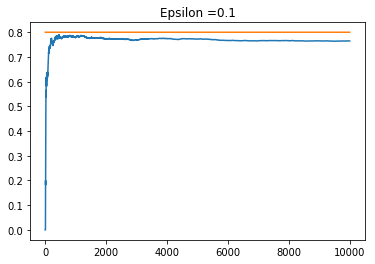

In [8]:
_ = experiment(N =10000,eps=0.1,bandit_probs = [0.2,0.4,0.6,0.8])

#### Comparing Epsilons

In [9]:
epsilons = [0.1,0.05,0.01,0.001]
bandit_probs =  [0.2,0.4,0.6,0.8]
N =10000

Epsilon:0.1
Mean estimated reward for Bandit 0:0.1968503937007874
Mean estimated reward for Bandit 1:0.4107142857142858
Mean estimated reward for Bandit 2:0.6374999999999998
Mean estimated reward for Bandit 3:0.7968110321051481
Total reward earned over 10000 trails: 7691.0
Overall win rate:0.7691
Number of times explored: 957(9.569999999999999%)
Number of times exploited: 9043(90.42999999999999%)
No of times optimal bandit selected: 9282 

Epsilon:0.05
Mean estimated reward for Bandit 0:0.214765100671141
Mean estimated reward for Bandit 1:0.45522388059701474
Mean estimated reward for Bandit 2:0.6148148148148147
Mean estimated reward for Bandit 3:0.8055729492798991
Total reward earned over 10000 trails: 7895.0
Overall win rate:0.7895
Number of times explored: 517(5.17%)
Number of times exploited: 9483(94.83%)
No of times optimal bandit selected: 9582 

Epsilon:0.01
Mean estimated reward for Bandit 0:0.20161290322580647
Mean estimated reward for Bandit 1:0.32432432432432445
Mean estimate

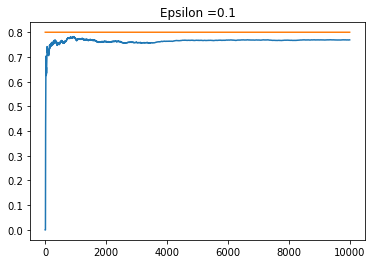

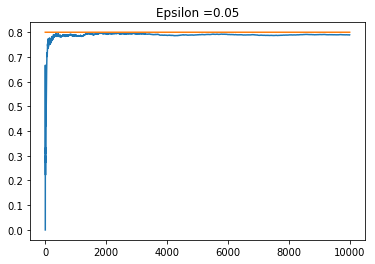

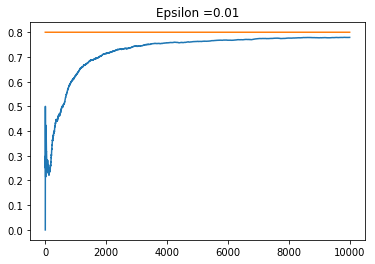

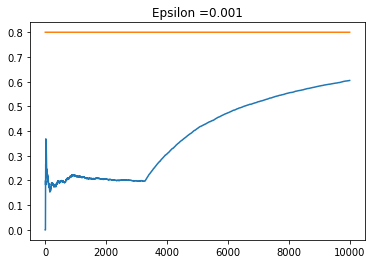

In [10]:
win_rates = [np.arange(10000)] # Add column for time step
for eps in epsilons:
    win_rate =  experiment(N = N,eps=eps,bandit_probs = bandit_probs )
    win_rates.append(win_rate)
    

In [11]:
df = pd.DataFrame(win_rates).T

In [12]:
df.columns = ['Time_Step'] + ['eps' + str(eps) for eps in epsilons] 
df['Upper Bound'] = np.ones(N)* np.max(bandit_probs)

A comparison between various possible values of $\epsilon$ are shown below

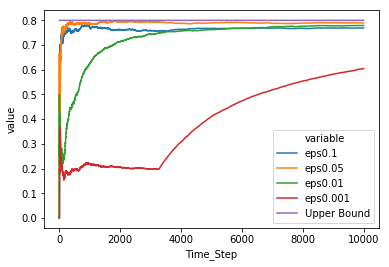

In [13]:
plt.figure()
sns.lineplot(x='Time_Step', y='value', hue='variable', 
             data=pd.melt(df,['Time_Step']))


In the above figure, using $\epsilon = 0.1 $ seems to quickly find the optimal bandit, but the high value of $\epsilon$ leads to unnecessary exploration. Decaying $\epsilon$ can be a solution to this problem 

### Epsilon Greedy with Decaying Epsilon

Consider $\epsilon$ that decays with time as follows

$ \epsilon(t) = \epsilon_0 \alpha^t $ where $\alpha \in (0,1)$

In [14]:
def epsilon_greedy_decay(bandits,eps,t):
    eps_decayed = eps*0.99**t
    if np.random.random() < eps_decayed:
        return np.random.randint(len(bandits)),'explore' #explore
    else:
        return np.argmax([b.p_estimate for b in bandits]),'exploit' #exploit
    

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
def experiment(N=1000,eps = 0.01,bandit_probs = [0.2,0.4,0.6,0.8]):
    bandits = [Bandit(p) for p in bandit_probs]
    
    rewards = np.zeros(N)
    explore_exploit_counter = {'explore':0,'exploit':0}
    num_optimal = 0
    optimal_action = np.argmax([b.p for b in bandits])
    
    
    #Carry out N trials
    
    for i in range(N):
        action,explore_flag = epsilon_greedy_decay(bandits,eps,i)
        explore_exploit_counter[explore_flag] += 1
        if action == optimal_action:
            num_optimal+=1
            
        #perform chosen action to receive reward
        r = bandits[action].pull()
        #Add to rewards log
        rewards[i] = r
        #Update reward estimate for bandit
        bandits[action].update(r)
        
    ##Print rewards estimated by agent
    print(f"Epsilon:{eps}")
    for j in range(len(bandits)):
        print(f"Mean estimated reward for Bandit {j}:{bandits[j].p_estimate}")
    
    print(f"Total reward earned over {N} trails: {sum(rewards)}")
    print(f"Overall win rate:{sum(rewards)/N}")
    print(f"Number of times explored: {explore_exploit_counter['explore']}({explore_exploit_counter['explore']/N*100}%)")
    print(f"Number of times exploited: {explore_exploit_counter['exploit']}({explore_exploit_counter['exploit']/N*100}%)")
    print(f"No of times optimal bandit selected: {num_optimal} \n")
    
    
    ##Plot results
    cumulative_rewards= np.cumsum(rewards)
    win_rate = cumulative_rewards/(np.arange(N)+1)
    plt.figure()
    plt.title("Epsilon ="+ str(eps))
    sns.lineplot(np.arange(N),win_rate)
    sns.lineplot(np.arange(N),np.max(bandit_probs))
    return(win_rate)
    

Epsilon:0.1
Mean estimated reward for Bandit 0:0.15384615384615385
Mean estimated reward for Bandit 1:0.5806451612903226
Mean estimated reward for Bandit 2:0.625
Mean estimated reward for Bandit 3:0.8025150905432584
Total reward earned over 10000 trails: 8007.0
Overall win rate:0.8007
Number of times explored: 12(0.12%)
Number of times exploited: 9988(99.88%)
No of times optimal bandit selected: 9940 



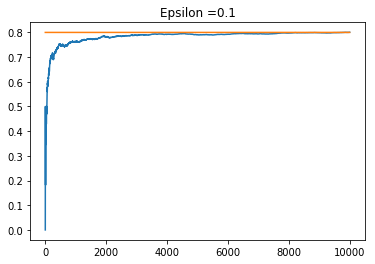

In [16]:
 win_rate_eps_decayed =  experiment(N = N,eps=0.1,bandit_probs = bandit_probs )

**Practically** an epsilon greedy algorithm when tuned well performs very well

### 2) Optimistic Initial Values

In this approach you set the inital win rate estimate for each bandit to a high value rather than 0. This causes the agent to try each bandit alteast once. You esentially trick the agent into exploration.

However, if you are unlucky and get a 0 reward for the highest value bandit on the first few tries, the agent could end up getting locked out of taking this action.

In [17]:
class Bandit:
    def __init__(self,p):
        self.p = p #intrinsic reward probability of bandit
        self.p_estimate = 0.95
        self.N = 1 #number of trails
        
    def pull(self):
        return np.random.random() < self.p
    
    def update(self,x):
        self.N += 1
        self.p_estimate = self.p_estimate + 1/self.N*(x - self.p_estimate)
        

In [18]:
from collections import Counter

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
def experiment(N=1000,bandit_probs = [0.2,0.4,0.6,0.8]):
    bandits = [Bandit(p) for p in bandit_probs]
    
    rewards = np.zeros(N)
    action_counter = Counter()
    num_optimal = 0
    optimal_action = np.argmax([b.p for b in bandits])
    
    
    #Carry out N trials
    
    for i in range(N):
        action = np.argmax([b.p_estimate for b in bandits])
        if action == optimal_action:
            num_optimal+=1
        action_counter[action]+=1
            
        #perform chosen action to receive reward
        r = bandits[action].pull()
        #Add to rewards log
        rewards[i] = r
        #Update reward estimate for bandit
        bandits[action].update(r)
        
    ##Print rewards estimated by agent
    
    for j in range(len(bandits)):
        print(f"Mean estimated reward for Bandit {j}:{bandits[j].p_estimate}")
        print(f"No of times Bandit {j} was selected: {action_counter[j]}")

    
    print(f"Total reward earned over {N} trails: {sum(rewards)}")
    print(f"Overall win rate:{sum(rewards)/N}")
    print(f"No of times optimal bandit selected: {num_optimal} \n")
    
    
    ##Plot results
    cumulative_rewards= np.cumsum(rewards)
    win_rate = cumulative_rewards/(np.arange(N)+1)
    plt.figure()
    sns.lineplot(np.arange(N),win_rate)
    sns.lineplot(np.arange(N),np.max(bandit_probs))
    return(win_rate)
    

Mean estimated reward for Bandit 0:0.475
No of times Bandit 0 was selected: 1
Mean estimated reward for Bandit 1:0.39
No of times Bandit 1 was selected: 4
Mean estimated reward for Bandit 2:0.6020960480240097
No of times Bandit 2 was selected: 9994
Mean estimated reward for Bandit 3:0.475
No of times Bandit 3 was selected: 1
Total reward earned over 10000 trails: 6018.0
Overall win rate:0.6018
No of times optimal bandit selected: 1 



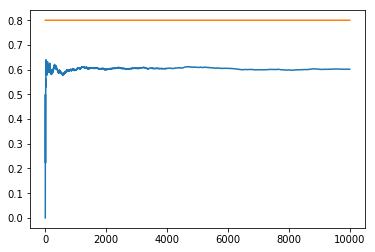

In [20]:
_ = experiment(N=10000,bandit_probs = [0.2,0.4,0.6,0.8])

### 3) UCB1

This is a **frequentist approach** to being optimistic in the face of uncertainty.

#### Hoeffding Inequality

Let $X_1$,....,$X_t$ be i.i.d random variables in $[0,1]$, and let $\bar{X_t} = \frac{1}{\tau} \sum_{\tau=1}^t X_t$ be the sample mean. Then:
$$ \mathbb{P}[\mathbb{E}[X] > \bar{X_t} + u] \leq e^{-2tu^2}$$

This gives the probability that the true mean is greater than the **estimated mean + some quantity (u)** i.e.UCB, has an upper bound that decreases exponentially as the size of the sample and the square of this quantity.

Given we estimate the value of an action by averaging the rewards, this can be restated as

$$ \mathbb{P}[Q(a) > \bar{Q_t}(a) + U_t(a)] \leq e^{-2N_t(a)U_t(a)^2}$$

We want to account for this uncertainity in the estimate of the value of an action/bandit. We do this by using the UCB estimate of the value of an action. We want to consider a high enough UCB such that the probability of the true mean being greater than this is very small(p)

$$ e^{-2N_t(a)U_t(a)^2} = p$$

$$U_t(a) = \sqrt{\frac{-log\ p}{2 N_t(a)}} $$

This gives the magnitude of uncertainty(referred to earlier as **some quantity (u)**)that we need to add to the estimated mean to minimize this probability.

Further, we want this probability to go to 0 as the number of samples increases. Using $p = t^{-4}$ gives

$$U_t(a) = \sqrt{\frac{2log\ t}{N_t(a)}} $$

This leads to the UCB algorithm

$$a_t = \underset{a \in \mathcal{A}} {argmax} Q(a) + \sqrt{\frac{2log\ t}{N_t(a)}} $$

#### Intuition

If the total number of actions taken($t$) is very large, but the number of times action $a$  has been taken is small, then the uncertainty in the action's value is very large leading to a higher UCB.


In [21]:
class Bandit:
    def __init__(self,p):
        self.p = p #intrinsic reward probability of bandit
        self.p_estimate = 0
        self.N = 0 #number of trails
        
    def pull(self):
        return np.random.random() < self.p
    
    def update(self,x):
        self.N += 1
        self.p_estimate = self.p_estimate + 1/self.N*(x - self.p_estimate)
        

In [22]:

def experiment(N=1000,bandit_probs = [0.2,0.4,0.6,0.8]):
    bandits = [Bandit(p) for p in bandit_probs]
    
    rewards = np.zeros(N)
    action_counter = Counter()
    num_optimal = 0
    optimal_action = np.argmax([b.p for b in bandits])
    
    
    #Carry out N trials
    
    for i in range(N):
        ucb = [bandits[j].p_estimate + np.sqrt((2*np.log(i+1))/(action_counter[j])) for j in range(len(bandits))]
        action = np.argmax(ucb)
        if action == optimal_action:
            num_optimal+=1
        action_counter[action]+=1
            
        #perform chosen action to receive reward
        r = bandits[action].pull()
        #Add to rewards log
        rewards[i] = r
        #Update reward estimate for bandit
        bandits[action].update(r)
        
    ##Print rewards estimated by agent
    
    for j in range(len(bandits)):
        print(f"Mean estimated reward for Bandit {j}:{bandits[j].p_estimate}")
        print(f"No of times Bandit {j} was selected: {action_counter[j]}")

    
    print(f"Total reward earned over {N} trails: {sum(rewards)}")
    print(f"Overall win rate:{sum(rewards)/N}")
    print(f"No of times optimal bandit selected: {num_optimal} \n")
    
    
    ##Plot results
    cumulative_rewards= np.cumsum(rewards)
    win_rate = cumulative_rewards/(np.arange(N)+1)
    plt.figure()
    sns.lineplot(np.arange(N),win_rate)
    sns.lineplot(np.arange(N),np.max(bandit_probs))
    return(win_rate)
    

C:\Users\learningmachine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\learningmachine\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Mean estimated reward for Bandit 0:0.13513513513513514
No of times Bandit 0 was selected: 37
Mean estimated reward for Bandit 1:0.3181818181818183
No of times Bandit 1 was selected: 66
Mean estimated reward for Bandit 2:0.6129032258064517
No of times Bandit 2 was selected: 341
Mean estimated reward for Bandit 3:0.8027417329426516
No of times Bandit 3 was selected: 9556
Total reward earned over 10000 trails: 7906.0
Overall win rate:0.7906
No of times optimal bandit selected: 9556 



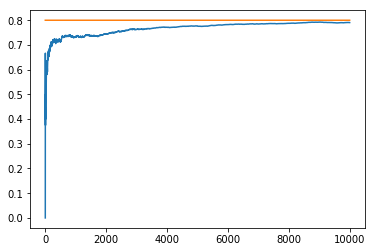

In [23]:
_ = experiment(N=10000,bandit_probs = [0.2,0.4,0.6,0.8])

### 4) Bayesian Bandits 

The Bayesian method requires us to specify a belief in the rewards distribution of each bandit. When actual rewards are observed for each bandit,this prior belief is updated using the Baye's rule to get a posterior belief in the rewards distribution of each bandit

$$\mathbb{P}\bigg(\frac{\theta}{D}\bigg) = \frac{\mathbb{P}(\theta)\ \mathbb{P}\bigg(\frac{D}{\theta}\bigg)}{\mathbb{P}(D)}$$

where: <br> $\mathbb{P}(\theta)$ is the prior <br>
$\mathbb{P}\bigg(\frac{D}{\theta}\bigg)$ is the likelihood <br>
$\mathbb{P}(D)$ is a normalizing factor given by $ \int_{\theta}\mathbb{P}(\theta)\ \mathbb{P}\bigg(\frac{D}{\theta}\bigg) d\theta $


### Example from Last Session

There are two bags. <br> 
Bag 1: 5 white balls and 6 blue balls. <br>
Bag 2: 3 white and 4 blue balls 

Here your prior belief is a ball can be blindly drawn from either bag.
$$\mathbb{P}[Bag1] = \mathbb{P}[Bag2] == 0.5 $$

Now we observe that the ball drawn is white.<br>
The likelihood of a white ball being drawn if Bag 1 is selected is given by

$$\mathbb{P}\bigg(\frac{ball = white}{Bag1} \bigg) = \frac{5}{11}$$

The likelihood of a white ball being drawn if Bag 12is selected is given by
$$\mathbb{P}\bigg(\frac{ball = white}{Bag2} \bigg) = \frac{3}{7}$$

The posterior probability of the bag selected being Bag 1 given the ball drawn is white is given by

$$\mathbb{P}\big(\frac{Bag1}{ball=white}\big) =  \frac{\mathbb{P}[Bag1] \mathbb{P}\bigg(\frac{ball = white}{Bag1} \bigg)}{\mathbb{P}[Bag1] \mathbb{P}\bigg(\frac{ball = white}{Bag1} \bigg) + \mathbb{P}[Bag2] \mathbb{P}\bigg(\frac{ball = white}{Bag2} \bigg)} = \frac{\frac{1}{2}\times\frac{5}{11}}{\frac{1}{2}\times\frac{5}{11} + \frac{1}{2}\times\frac{3}{7}} = \frac{35}{68} $$

This computation becomes extremely simple if a Beta distribution is used as a prior and a Bernoulli distribution is used as the likelihood function. The posterior will also be in the form of a Beta distribution because they are [conjugate distributions](https://en.wikipedia.org/wiki/Conjugate_prior).

If the prior distribution of the reward is given by $\beta(a=10,b=10)$

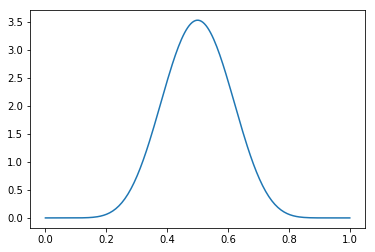

In [24]:
from scipy.stats import beta
x = np.linspace(0,1,200)
y = beta.pdf(x,a=10,b=10)
plt.plot(x,y)

And a bandit gave a sequence of  N(=10) rewards comprising z(=8) ones, the posterior is also a Beta distribution given by 
$$ Beta(a+z,b+(N-z)) $$

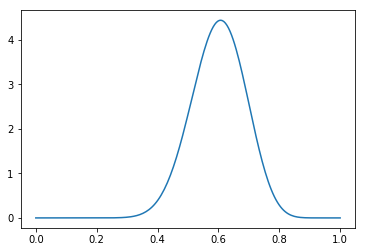

In [25]:
x = np.linspace(0,1,200)
y = beta.pdf(x,a=10+8,b=10 + 2)
plt.plot(x,y)


Once we have a posteror reward distribution for each bandit, we will sample from them and do an argmax from the sample to select the bandit. This is called [**Thompson Sampling**](https://en.wikipedia.org/wiki/Thompson_sampling)

In [26]:
class Bandit:
    def __init__(self,p):
        self.p = p #intrinsic reward probability of bandit
        self.a = 1
        self.b = 1
        self.N = 0 #number of trails
        
    def pull(self):
        return np.random.random() < self.p
    
    def sample(self):
        return np.random.beta(self.a,self.b)
    
    def update(self,x):
        self.a += x
        self.b += 1 - x
        self.N += 1
        
        

In [27]:
def plot(bandits,trial):
    x = np.linspace(0,1,200)
    for b in bandits:
        y = beta.pdf(x,b.a,b.b)
        plt.plot(x,y,label = f"real p:{b.p:.4f}, win rate = {b.a -1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()
        

In [28]:
def experiment(N=10000,bandit_probs = [0.2,0.4,0.6,0.8]):
    bandits = [Bandit(p) for p in bandit_probs]
    plot_points = [5,10,20,50,100,200,500,1000,1500,1999,N]
    rewards = np.zeros(N)
    action_counter = Counter()
    optimal_action = np.argmax([b.p for b in bandits])
    num_optimal = 0
        
    for i in range(N):
        #Thompson sampling
        action = np.argmax([b.sample() for b in bandits])
        action_counter[action]+=1
        
        if action == optimal_action:
            num_optimal += 1
        
        
        #plot posterior reward distribution
        if i in plot_points:
            plot(bandits,i)
            
        #perform actions to get reward
        r = bandits[action].pull()
        
        #update rewards
        rewards[i] = r
        
        #Perform Bayesian update on bandit's reward distribution
        bandits[action].update(r)
    
    for j in range(len(bandits)):
        print(f"No of times Bandit {j} was selected: {action_counter[j]}")

    
    print(f"Total reward earned over {N} trails: {sum(rewards)}")
    print(f"Overall win rate:{sum(rewards)/N}")
    print(f"No of times optimal bandit selected: {num_optimal} \n")
    
        

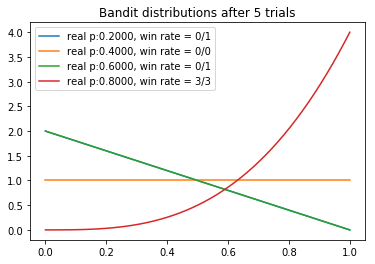

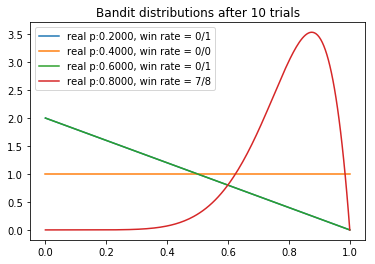

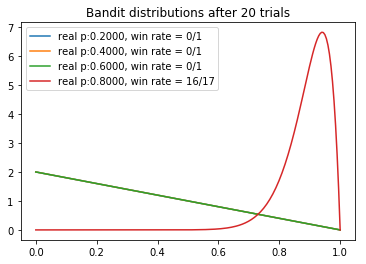

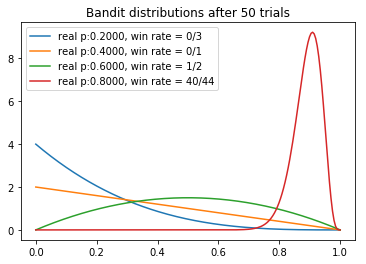

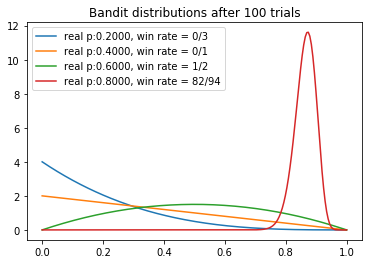

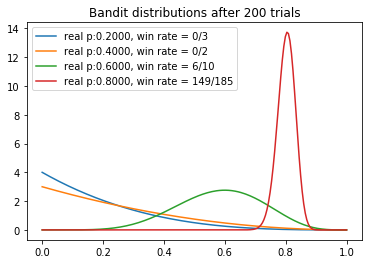

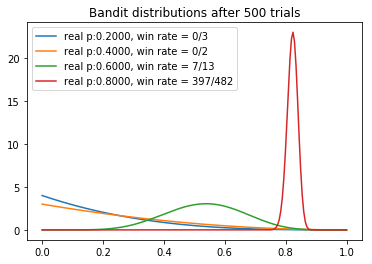

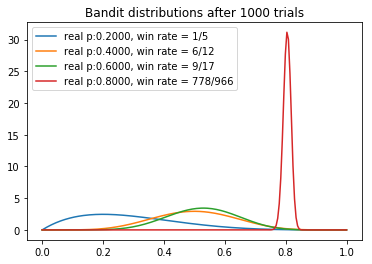

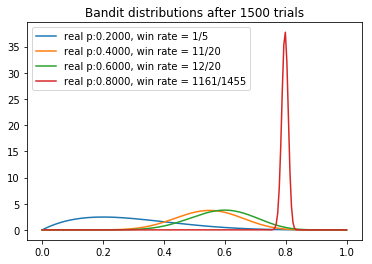

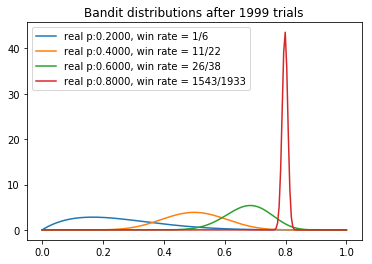

No of times Bandit 0 was selected: 7
No of times Bandit 1 was selected: 23
No of times Bandit 2 was selected: 70
No of times Bandit 3 was selected: 9900
Total reward earned over 10000 trails: 8004.0
Overall win rate:0.8004
No of times optimal bandit selected: 9900 



In [29]:
experiment(N=10000,bandit_probs = [0.2,0.4,0.6,0.8])

Multi Armed Bandits are a more efficient alternative to A/B tests for running experiments.By assigning incoming traffic to better performing arms sooner, the overall cost of experimentation will be lower.

**Bayesian Bandits achieves the theoretical minimum possible regret given by the Lai and Robbins lower bound.** 

## Reinforcement Learning

![RL](RL.png)

### Elements of an RL system

1) **Agent** : Entity learning about the environment and making decisions. We need to specify a learning algorithm for the agent that allows it to learn a policy <br>
2) **Environment**: Everything outside the agent, including other agents <br>
3) **Rewards**: Numerical quanitities that represent feedback from the environment that an agent tries to maximize <br>
    - Goal reward representation: 1 for goal, 0 otherwise
    - Action penalty representation: -1 for not goal, 0 once goal is reached
4) **State**: A representation of the environment. At time step $t$,the agent is in state $S_t \in \mathcal{S}$ where $\mathcal{S}$ is the set of all possible states <br>
5) **Action**: At time step $t$, an agent takes an action $A_t \in \mathcal{A}(S_t)$ where $\mathcal{A}(S_t)$ is the set of actions available in state $S_t$ <br>
6) **Policy**: A policy tells the agent what action to take in a given state. $\pi(a|S$)


A policy can be deterministic i.e. there is one action that is deterministically selected in a given state $\pi(s)=a$,
or   stochastic i.e. the policy maps a state onto a set of probabilties for taking each action. $\mathbb{P}[a^i|s] < 1$  subject to $ \sum_i \mathbb{P}[a^i|s] =1$

### Markov Decision Process

In an MDP, the environment is completely characterized by the **transition dynamics equation** $$p(s',r|s,a)$$
That is, the probability of each possible value for $s'$ and $r$ depends only on the immediately preceding state and action, $s$ and $a$, and, given them, not at all on earlier states and actions.

**The state must include information about all aspects of the past agent–environment interaction that make a difference for the future. If it does, then the state is said to have the *Markov property***

If the transtion dynamics equation is fully known by the agent, it means an optimal policy can be computed without interacting with the environment. This is **planning**. Some kind of search algorithm can be used here.<br>

When the environment is not fully known, the agent has to learn by interacting with the environment. i.e. **learning**. If an agent constructs a model of the environment , it is called **model based RL**, else it is called **model free RL**.

If you are contructing a self driving car, learning from real experience can be too expensive so you want to build a model of then environment which you can query for information to make decisions.

When an agent in state $S_t$ takes an action $A_t$ as prescribed by a policy $\pi$, it transitions to a state $S_{t+1}$ and receives a reward $R_{t+1}$. The Agent interacting with the **MDP** environment thus gives rise to a sequence or trajectory

$$S_0,A_0,R_1,S_1,A_1,R_2,S_2,...$$

|  Multi Armed Bandit               |Markov Decision Process                 |
|-----------------------------------|----------------------------------------|
|Maximize immediate reward          |Maximize long term reward               |
|Reward distribution is stationary  |Reward distribution is non-stationary   |
|One-step decision making problem   |Sequential decision making problem      |

Long term reward or return is formally defined as the discounted sum of future rewards.

$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma R_{t+3} +... = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} $$

$$ = R_{t+1} + \gamma G_{t+1} $$

The **State - Value function** of a state $s$ under a policy $\pi$,is the expected return from following policy $\pi$ when starting in state $s$
$$v_{\pi}(s) \doteq \mathbb{E}_{\pi}[G_t | S_t =s]  $$

The **Action-Value function** is the value of taking action $a$ in state $s$ under policy $\pi$

$$q_{\pi}(s,a) \doteq \mathbb{E}_{\pi}[G_t| S_t =s ,A_t=a] $$

**The Bellman expectation equation for the state value function** follows naturally from the above defintion of the state value function.

$$v_{\pi}(s) \doteq \mathbb{E}[G_t | S_t =s]  $$ <br>
$$ = \mathbb{E}_{\pi}[R_{t+1} + \gamma G_{t+1} | S_t =s]  $$ <br>
$$ = \mathbb{E}_{\pi}[R_{t+1}|S_t = s] + \gamma \mathbb{E}_{\pi}[G_{t+1}|S_{t+1} = s'] $$  <br>
$$ \sum_{a} \pi(a|s) \sum_{s',r}  p(s',r|s,a) [r + \gamma v_{\pi}(s')] $$

This is easily understood from the backup diagram shown below.

![backup](backup.png)

The value of a state $s$ is obtained by considering all possible paths to all possible successor states , and weighting the rewards obtained and value of these successor states by the probabilities of taking each path.

**The Bellman expectation equation for the action value function** is similarly given by

$$ q_{\pi}(s,a) = \sum_{s',r} p(s',r|s,a)[r + \gamma \sum_{a'} \pi(a'|s')q_{\pi}(s',a')] $$

**The optimal state value function** $v_*(s)$ is the maximum value function over all policies

$$v_*(s) = \underset{\pi}max\ v_{\pi}(s) $$

**The optimal action-value function** $q_*(s,a)$ is the maximum action-value function over all policies

$$q_*(s,a) = \underset{\pi}max\ q_{\pi}(s,a) $$

### Optimal Policy

**Theorem** <br>
For any MDP <br>
- There exists an optimal policy $\pi_*$, that is better than or equal to all other policies, $\pi_* \ge \pi, \forall \pi $ 
- All optimal policies achieve the optimal value function $v_{\pi_*} = v_*(s)$
- All optimal policies achieve optimal action-value function, $q_{\pi_*}(s,a) = q_*(s,a)$


An optimal policy can be found by maximizing over the optimal value function
$$\pi_*(s) = \underset{a} \arg\max q_*(s,a)$$

$q_*(s,a)$ is given by the **Bellman optimality equations**

**The Bellman Optimality equation for state values** is given by

$$ v_*(s) =  \max_{a} \sum_{s',r}  p(s',r|s,a) [r + \gamma v_{\pi}(s')] $$

**The Bellman Optimality equation for action-values** is given by

$$ q_{*}(s,a) = \sum_{s',r} p(s',r|s,a)[r + \gamma\ \underset{a'}max \ \pi(a'|s')q_{\pi}(s',a')] $$

**All RL Algorithms solve the Bellman Equations exactly or approxiamtely**

![RL algo map](RL Algo map.png)

## Policy Iteration

Policy iteration is an algorithm to do **prediction** i.e evaluate a policy and **control** i.e selecting an optimal policy.
It uses **iterative policy evaluation** to evaluate a policy and **policy improvement** to improve the policy.

### Iterative Policy Evaluation

This algorithm iteratively applies the **Bellman Expectation equation for the state value function** to update the value function until it stabilizes. Each iteration of IPE updates the value of every state once to produce the new approximate value function $v_{k+1}$

![IPE](IPE.png)

### Policy Improvement

A policy can be improved simply by acting greedily with respect to the value function of the current policy $v_{\pi}$. <br>
According to the **policy improvement theorem**, greedifying a policy(even a random policy) will produce a strict improvement unless the policy were already optimal.


To improve an existing policy,act greedily with respect to a one-step lookahead for each state.
$$\pi'(s) \doteq  \underset{a}\arg\max q_{\pi}(s,a) $$

where $$ q_{\pi}(s,a)  = \sum_{s',r} p(s',r|s,a)[r + \gamma \sum_{a'} \pi(a'|s')q_{\pi}(s',a')] $$ 

$$ =  \sum_{s',r} p(s',r|s,a)[r + \gamma v_{\pi}(s')] $$ 

Note the above is just the **Bellman Optimality Equation for State Values**

The greedy policy takes the action that looks best in the short term - a one step lookahead.

### Algorithm

Start with a random policy. Carry out iterative policy evaluation , now do improvement by acting greedily. Evaluate again..Repeat this process until the policy shows no improvement. By the policy improvement theorem, if this happens, we have identified the optimal policy.

![PI](policy_iteration.png)

## RL in Cliffworld

![](cliffworld.png)

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
class Cliff:
    def __init__(self,rows,cols):
        self.rows = rows
        self.cols = cols
        #the current position of the agent
        self.current_state = (rows-1,0)
        #The goal position
        self.goal = (rows-1,cols-1) 
        self.gamma = None
        
        #Permissible actions for each state: #Up, down,left and right are all possible except for cliff and goal states.
        actions = {} # dict of form {(row,col): action}
        for i in range(rows):
            for j in range(cols):
                if not(i == rows - 1 and  j >0) :
                    actions[(i,j)] = ['U','D','L','R']
        #Note terminal states: goal and cliff states don't have leginitmate actions
        self.actions = actions         
                
    def set_rewards(self,reward_type='goal_reward'): #reward can be action penalty or goal reward
        # rewards will be a numpy array of dimensions rowsxcols and gives the reward for arriving in each state
        if reward_type == 'goal_reward':
            rewards = np.zeros((self.rows,self.cols))
            #set reward for bottom row (cliff + 2 cells) : -100
            rewards[self.rows-1,:] = -100
            #set reward for start and goal positions to 0 and 1
            rewards[self.rows-1,0] = 0
            rewards[self.rows-1,self.cols-1] = 1
        elif reward_type == 'action_penalty':
            rewards = np.ones((self.rows,self.cols))*-0.1
            #set reward for bottom row(cliff+2 cells) : -100
            rewards[self.rows-1,:] = -100
            #set reward for start and goal positions to 0 and 1
            rewards[self.rows-1,0] = -0.1
            rewards[self.rows-1,self.cols-1] = 0 
        
        self.rewards = rewards

    def set_discount(self,gamma):
        self.gamma = gamma
    
    def set_state(self,i,j):
        self.current_state = (i,j)
        
    def present_state(self):
        return self.current_state
    
    def is_terminal(self,s):
        return s not in self.actions
    
    def move(self,action): 
        #Updates current state and returns reward
        assert self.current_state in self.actions, "Epsiode has terminated"
        
        (i,j) = self.current_state
        
        if action == "U":
            i += -1
        elif action == "D":
            i += 1
        elif action == "L":
            j -= 1
        elif action == "R":
            j += 1
    
        # If i < 0 or >= rows OR if j < 0 or j >= Cols it means agent has gone out of the grid and should be returned to its
        #original state
        
        
        if i < 0:
            self.set_state(0,j)
        elif i >= self.rows:
            self.set_state(self.rows-1,j)
        elif j < 0:
            self.set_state(i,0)
        elif j >= self.cols:
            self.set_state(i,self.cols-1)
        else:    
            self.set_state(i,j)
        
        return self.rewards[self.current_state]
    

        
    
    def show(self):
        df = pd.DataFrame(self.rewards)
        sns.heatmap(df, cmap ='RdYlBu', linewidths = 0.30, annot = True) 
    
    def all_states(self):
        return [(i,j) for i in range(self.rows) for j in range(self.cols)]
        
        

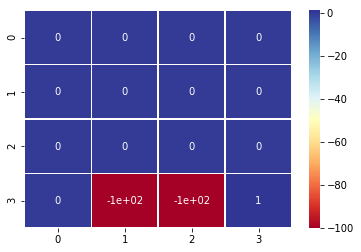

In [31]:
cliff = Cliff(4,4)
cliff.set_rewards(reward_type='goal_reward')
cliff.set_discount(0.9)
cliff.show()

In [32]:
cliff.all_states()

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

### Policy Evaluation

In [33]:
import random
def create_policy(environment,policy_type='random stochastic'):
    '''Create a random policy.
        Inputs:
            environmnet: An object of 'Cliff' class
            policy_type: Can be stochastic or deterministic
           "stochastic" policy assigns equal probability to each of permissible actions.
           "deterministic" assigns a random permissible action to each state
        Output:
            A random policy
    '''
    env = environment
    rows = env.rows
    cols = env.cols
    actions = env.actions
    policy = {}
    if policy_type == 'random stochastic':
        for state in actions.keys():
            possible_actions = actions[state]
            n_actions = len(possible_actions)
            policy[state] = {action:1.0/n_actions for action in possible_actions}
    
    
    if policy_type == 'random deterministic':
         for state in actions.keys():
            possible_actions = actions[state]
            action_taken = random.choice(possible_actions)
            policy[state] = {action_taken:1.0}
    
    if policy_type == 'empty':
         for state in actions.keys():
            policy[state] = {}
    
    
    return policy
        
    

In [34]:
direction = {"D":"↓", "U":"↑","L":"←","R":"→"}
def print_policy(policy,env):
    p = np.zeros((env.rows,env.cols))
    df = pd.DataFrame(p)
    df.iloc[env.rows-1,1:(env.cols-1)] = 'X'
    df.iloc[env.rows-1,env.cols-1] = 'G'
    for state,action_dict in policy.items():
        i,j = state
        action = list(action_dict.keys())
        df.iloc[i,j] = direction[action[0]]
    return df

In [35]:
stochastic_random_policy  = create_policy(cliff,policy_type='random stochastic')
stochastic_random_policy

{(0, 0): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (0, 1): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (0, 2): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (0, 3): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (1, 0): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (1, 1): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (1, 2): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (1, 3): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (2, 0): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (2, 1): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (2, 2): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (2, 3): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25},
 (3, 0): {'U': 0.25, 'D': 0.25, 'L': 0.25, 'R': 0.25}}

In [36]:
deterministic_random_policy  = create_policy(cliff,policy_type='random deterministic')
print_policy(deterministic_random_policy,cliff)

,0,1,2,3
0,↓,↓,→,↓
1,↓,↓,↑,←
2,↓,↓,↓,←
3,↑,X,X,G


In [37]:
good_policy = {(0, 0): {'D': 1.0},
 (0, 1): {'D': 1.0},
 (0, 2): {'D': 1.0},
 (0, 3): {'D': 1.0},
 (1, 0): {'D': 1.0},
 (1, 1): {'D': 1.0},
 (1, 2): {'D': 1.0},
 (1, 3): {'D': 1.0},
 (2, 0): {'R': 1.0},
 (2, 1): {'R': 1.0},
 (2, 2): {'R': 1.0},
 (2, 3): {'D': 1.0},
 (3, 0): {'U': 1.0}}
print_policy(good_policy,cliff)

,0,1,2,3
0,↓,↓,↓,↓
1,↓,↓,↓,↓
2,→,→,→,↓
3,↑,X,X,G


In [38]:
def evaluate_policy(policy,env,epsilon = 0.01):
    '''
    Function to evaluate a policy i.e. value function of each state when following a policy
    Applies Bellman Expectation Equation
    '''
    states = env.actions.keys() # all non terminal states
    
    #Set value of all states to 0
    V = np.zeros((env.rows,env.cols))
    gamma = env.gamma
    
    while True:
        delta  = 0
        for state in states:
            i,j = state
            old_v = V[state]
            new_v = 0
            for action,pi in policy[state].items():
                env.set_state(i,j)
                #Move agent to get reward
                reward = env.move(action)
                new_v += pi *(reward+gamma*V[env.present_state()])
                
            V[state] = new_v
            delta = max(delta,np.abs(old_v - V[state]))
        if delta <epsilon:
            break
    return V
                
            
        
    

In [39]:
evaluate_policy(stochastic_random_policy,cliff)

array([[-16.1818205 , -16.28305327, -14.80094325, -12.205613  ],
       [-23.30304215, -25.12131457, -22.50823992, -15.05013879],
       [-38.97750404, -49.5625388 , -45.0700198 , -17.13113027],
       [-61.39832347,   0.        ,   0.        ,   0.        ]])

In [40]:
V = evaluate_policy(deterministic_random_policy,cliff)
V

array([[   0.,  -81.,    0.,    0.],
       [   0.,  -90.,    0.,    0.],
       [   0., -100., -100.,  -90.],
       [   0.,    0.,    0.,    0.]])

In [41]:
evaluate_policy(good_policy,cliff)

array([[0.59049, 0.6561 , 0.729  , 0.81   ],
       [0.6561 , 0.729  , 0.81   , 0.9    ],
       [0.729  , 0.81   , 0.9    , 1.     ],
       [0.6561 , 0.     , 0.     , 0.     ]])

## Policy Improvement

In [42]:
def improve_policy(policy,env,V):
    ''' Function to greedily improve a given policy using the Bellman Optimality Equation
    Inputs:
        policy: policy to be improves
        env: instance of the environment
        V: State value function for the policy
    '''
    states = env.actions.keys() # all non terminal states
    policy = create_policy(env,policy_type='empty')
    gamma = env.gamma
    for state in states:
        i,j = state
        action_values =[]
        actions = env.actions[state]
        for action in actions:
                env.set_state(i,j)
                #Move agent to get reward
                reward = env.move(action)
                v = reward+gamma*V[env.present_state()]
                action_values.append(v)
        
        optimal_action = actions[np.argmax(action_values)] #Find action with maximum action value
        policy[state][optimal_action] = 1 #Set probability of this action to 1
    
    return policy
        

In [43]:
improved_policy = improve_policy(deterministic_random_policy,cliff,V)

So we started with the below policy

In [44]:
print_policy(deterministic_random_policy,cliff)

,0,1,2,3
0,↓,↓,→,↓
1,↓,↓,↑,←
2,↓,↓,↓,←
3,↑,X,X,G


We evaluated the policy

In [45]:
V = evaluate_policy(deterministic_random_policy,cliff)
V

array([[   0.,  -81.,    0.,    0.],
       [   0.,  -90.,    0.,    0.],
       [   0., -100., -100.,  -90.],
       [   0.,    0.,    0.,    0.]])

And we improved the policy

In [46]:
print_policy(improved_policy,cliff)

,0,1,2,3
0,↑,←,↑,↑
1,↑,←,↑,↑
2,↑,←,↑,↓
3,↑,X,X,G


In [47]:
evaluate_policy(improved_policy,cliff)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.]])

## Policy Iteration

The polcy iteration algorithm simply alternates between policy evaluation and policy improvement until a stable policy is found

In [48]:
def policy_iteration(env):
    '''
    Identify the optimal policy for the given environment
    '''
    history = []
    policy = create_policy(env,policy_type='random deterministic') 
    while True:
        history.append(print_policy(policy,cliff))
        #Carry out policy evaluation
        V = evaluate_policy(policy,env,epsilon = 0.01)
        
        #Carry out policy improvement
        new_policy = improve_policy(policy,env,V)
        
        if policy == new_policy:#if polcy is stable stop
            break
        
        policy = new_policy
        
    return (policy,V,history)
        

The optimal policy has been learnt as shown below

In [49]:
optimal_policy,v,history = policy_iteration(cliff)
print_policy(optimal_policy,cliff)

,0,1,2,3
0,↓,↓,↓,↓
1,↓,↓,↓,↓
2,→,→,→,↓
3,↑,X,X,G


The history of learning is shown below

In [50]:
for df in history:
    print(df)
    print("\n")

   0  1  2  3
0  ↓  ↑  →  ↓
1  →  ↓  ↑  ←
2  →  ←  ↓  ↓
3  ↓  X  X  G


   0  1  2  3
0  ↑  ↑  ↑  ↑
1  ↑  ↑  ↑  ↓
2  ↑  ↑  →  ↓
3  ↑  X  X  G


   0  1  2  3
0  ↑  ↑  ↑  ↓
1  ↑  ↑  ↓  ↓
2  ↑  →  →  ↓
3  ↑  X  X  G


   0  1  2  3
0  ↑  ↑  ↓  ↓
1  ↑  ↓  ↓  ↓
2  →  →  →  ↓
3  ↑  X  X  G


   0  1  2  3
0  ↑  ↓  ↓  ↓
1  ↓  ↓  ↓  ↓
2  →  →  →  ↓
3  ↑  X  X  G


   0  1  2  3
0  ↓  ↓  ↓  ↓
1  ↓  ↓  ↓  ↓
2  →  →  →  ↓
3  ↑  X  X  G




## Value Iteration

Policy iteration carries out iterative policy evaluation which is an interative and potentially expensive process. Finding the true value $v_{\pi}$ using IPE is not necessary to guarantee that we converge to the optimal policy.

Value iteration is almost identicall to iterative policy evaluation. It simply takes the **Bellman Expectation equation for state values** used in IPE
$$ v_{k+1}(s) \doteq \sum_{a} \pi(a|s) \sum_{s',r}  p(s',r|s,a) [r + \gamma v_{\pi}(s')] $$

It then replaces a summation over the actions with a max over the actions
$$ v_{k+1}(s) \doteq \max_{a} \sum_{s',r}  p(s',r|s,a) [r + \gamma v_{\pi}(s')] $$

In fact this is the **Bellman Optimality Equation** being deployed as an update rule.

The algorithm is given below:

![value_iteration](value_iteration.png)

In [72]:
def value_iteration(env,eps):
    '''
    Function to determine an optimal policy using value iteration
    Inputs:
        env: object of environment class
        eps: Epsilon to determine convergence
    Returns:
        Optimal policy
    
    
    '''
    states = env.actions.keys() # all non terminal states
    policy = create_policy(env,policy_type='empty')
    gamma = env.gamma
    
    V = np.random.rand(env.rows,env.cols)
    V[env.rows-1,env.cols-1] = 0
    
    while True:
        delta = 0
        for state in states:
            i,j = state
            v_old = V[i,j]
            action_values =[]
            actions = env.actions[state]
            for action in actions:
                    env.set_state(i,j)
                    #Move agent to get reward
                    reward = env.move(action)
                    v = reward+gamma*V[env.present_state()]
                    action_values.append(v)
            v_max = np.max(action_values)
            V[i,j] = v_max
            delta = max(delta,np.abs(v_old-v_max))
        
        if delta < eps: #Output a deterministic policy 
                for state in states:
                    i,j = state
                    action_values =[]
                    actions = env.actions[state]
                    for action in actions:
                            env.set_state(i,j)
                            #Move agent to get reward
                            reward = env.move(action)
                            v = reward+gamma*V[env.present_state()]
                            action_values.append(v)
        
                    optimal_action = actions[np.argmax(action_values)] #Find action with maximum action value
                    policy[state][optimal_action] = 1 #Set probability of this action to 1
                
                return policy


In [74]:
optimal_policy = value_iteration(cliff,0.01)

In [75]:
print_policy(optimal_policy,cliff)

,0,1,2,3
0,↓,↓,↓,↓
1,↓,↓,↓,↓
2,→,→,→,↓
3,↑,X,X,G


## References

### Articles and Blogs

1) [Multi Armed Bandits at Stitch Fix](https://multithreaded.stitchfix.com/blog/2020/08/05/bandits/) <br>
2) [A Long Peek into RL](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html)

### Courses

1) [David Silver Course at UCL](https://www.davidsilver.uk/teaching/) <br>
2) [Coursera RL Specialization](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning) [Notes](https://www.notion.so/Coursera-MOOC-784382797f00445483b0252d409d7eae) <br>
3) [Udemy Course](https://www.udemy.com/course/artificial-intelligence-reinforcement-learning-in-python/) <br>

### Books

[Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf)